# Quantization and the WLPAC

So far we have coded:

* `wfir()`, which takes an audio signal `x[n]` and outputs a whitened, smaller remainder signal `r[n]`
* `wfir_reconstruct()`, which takes a remainder signal `r[n]` and tries to reconstruct the original signal `x[n]`

The advantage of having a smaller-valued, whiter `r[n]` is that we can quantize it and save some space. By adding some steps above, we come up with an audio codec ([1], [2]):

* `wfir()`, which takes an audio signal `x[n]` and outputs a whitened, smaller remainder signal `r[n]`
* quantize `r[n]`
* `wfir_reconstruct()`, which takes a remainder signal `r[n]` and tries to reconstruct the original signal `x[n]`

In [1]:
import numpy


def quantize(x: numpy.ndarray, ratio: float):
    bins = numpy.linspace(min(x), max(x), int(ratio*float(len(x))))
    inds = numpy.digitize(x, bins)
    return inds, bins


x = numpy.sin(numpy.linspace(-numpy.pi, numpy.pi, 20))
q1, b1 = quantize(x, 0.5)
q2, b2 = quantize(x, 0.7)
q3, b3 = quantize(x, 0.9)

In [2]:
def unquantize(binned: numpy.ndarray, bins: numpy.ndarray):
    ret = []
    for b in binned:
        ret.append(bins[b-1])
    return numpy.asarray(ret)


x1 = unquantize(q1, b1)
x2 = unquantize(q2, b2)
x3 = unquantize(q3, b3)

In [3]:
import matplotlib.pyplot as plt


fig1, ax1 = plt.subplots(1, 1, figsize=(10, 7))
ax1.set_title(r'quantized sinewave')
ax1.set_xlabel('n (samples)')
samples = numpy.arange(len(x))
ax1.plot(samples, x, color='b', linestyle=':', label='x[n]')
ax1.plot(samples, x1, color='r', linestyle='--', label='x\'[n], 0.5')
ax1.plot(samples, x2, color='g', linestyle='--', label='x\'[n], 0.7')
ax1.plot(samples, x3, color='y', linestyle='--', label='x\'[n], 0.9')
ax1.legend(loc='upper right')
ax1.grid()

fig1.tight_layout()
plt.show()

<Figure size 1000x700 with 1 Axes>

The information we need to undo the quantization is:

* `bins = numpy.linspace(min(x), max(x), int(ratio*float(len(x))))`, i.e. the 3 args to linspace to rebuild `bins`
* q, the quantized/binned array

In [4]:
def quantize(x, ratio: float):
    min_x = min(x)
    max_x = max(x)
    len_b = int(ratio*float(len(x)))
    bins = numpy.linspace(min_x, max_x, len_b)
    inds = numpy.digitize(x, bins)
    return inds, min_x, max_x, len_b


def unquantize(binned, l, r, lb) -> numpy.ndarray:
    bins = numpy.linspace(l, r, lb)
    ret = []
    for b in binned:
        ret.append(bins[b-1])
    return numpy.asarray(ret)


x = numpy.sin(numpy.linspace(-numpy.pi, numpy.pi, 200))
q1, l, r, lb = quantize(x, 0.75)
x1 = unquantize(q1, l, r, lb)

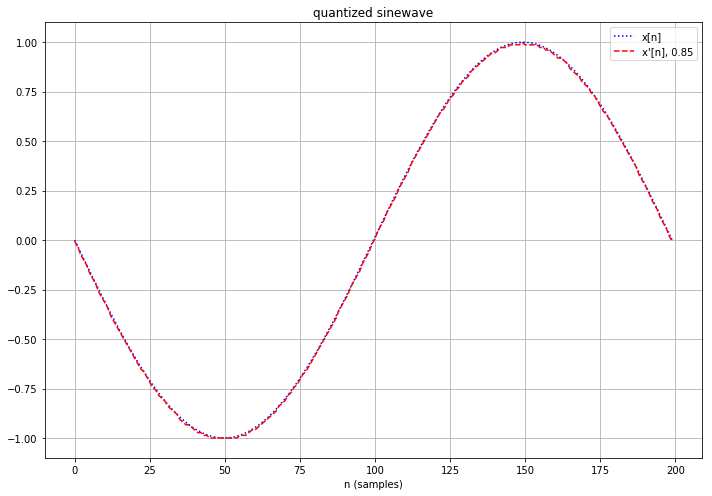

In [5]:
fig2, ax2 = plt.subplots(1, 1, figsize=(10, 7))
ax2.set_title(r'quantized sinewave')
ax2.set_xlabel('n (samples)')
samples = numpy.arange(len(x))
ax2.plot(samples, x, color='b', linestyle=':', label='x[n]')
ax2.plot(samples, x1, color='r', linestyle='--', label='x\'[n], 0.85')
ax2.legend(loc='upper right')
ax2.grid()

fig2.tight_layout()
plt.show()

## WLPAC

We have all the pieces we need. Let's build the WLPAC.

In [6]:
import numpy, scipy, scipy.signal


def bark_warp_coef(fs):
        return 1.0674 * numpy.sqrt((2.0 / numpy.pi) * numpy.arctan(0.06583 * fs / 1000.0)) - 0.1916
    
    
def warped_remez_coefs(fs, order):
    l = 20
    r = min(20000, fs/2 - 1)
    t = 1
      
    c = scipy.signal.remez(order+1, [0, l-t, l, r, r+t, 0.5*fs], [0, 1, 0], fs=fs)
    return c.tolist()

    
def wfir(x: numpy.ndarray, fs: float, order: int) -> numpy.ndarray:
    a = bark_warp_coef(fs)

    B = [-a.conjugate(), 1]
    A = [1, -a]
    ys = [0] * order

    ys[0] = scipy.signal.lfilter(B, A, x)
    for i in range(1, len(ys)):
        ys[i] = scipy.signal.lfilter(B, A, ys[i - 1])
        
    c = warped_remez_coefs(fs, order)

    x_hat = c[0] * x
    for i in range(order):
        x_hat += c[i+1] * ys[i]

    r = x - x_hat
    return r

def wfir_reconstruct(r: numpy.ndarray, fs: float, order: int) -> numpy.ndarray:
    def wfir_reconstruct_numerator(a, M):
        n = (numpy.poly1d([1, -a]))**M
        return n.c
    
    
    def wfir_reconstruct_denominator(a, M, c):
        if len(c) != M+1:
            raise ValueError('len filter coefficient array must be order+1')
        expr1 = (numpy.poly1d([1, -a]))**M
        i = 0
        expr2 = c[i]*(numpy.poly1d([-a, 1])**0)*(numpy.poly1d([1, -a]))**(M-0)
        for i in range(1, len(c)):
            expr2 += c[i]*(numpy.poly1d([-a, 1])**i)*(numpy.poly1d([1, -a]))**(M-i)
        den = expr1 - expr2
        return den.c
    
    
    a = bark_warp_coef(fs)
    c = warped_remez_coefs(fs, order)
    
    B = wfir_reconstruct_numerator(a, order)
    A = wfir_reconstruct_denominator(a, order, c)
    
    x = scipy.signal.lfilter(B, A, r)
    return x

In [7]:
from IPython.display import Audio
import scipy.io, scipy.io.wavfile


music_clip = './music.wav'
fs, x = scipy.io.wavfile.read(music_clip)              
Audio(x, rate=fs)

In [8]:
r = wfir(x, fs, 1)
q, l_, r_, lb = quantize(r, 0.5)
r_prime = unquantize(q, l_, r_, lb)
x_prime = wfir_reconstruct(r_prime, fs, 1)
Audio(x_prime, rate=fs)

My final contention, which makes the entire experiment worth it, is that it's somehow more space-efficient to save these outputs as compared to the original wav file.

```python3
r = wfir(x, fs, 1)
q, l_, r_, lb = quantize(r, 0.5)
```

In [9]:
from wlpac import wlpac_encode, wlpac_decode


wlpac_encode('music.wav', 'music.wlpac', quality=0.3)
wlpac_decode('music.wlpac', 'music_roundtrip.wav')

fs, x = scipy.io.wavfile.read('music.wav')
fs, x_wlpac = scipy.io.wavfile.read('music_roundtrip.wav')

Wrote music.wlpac with quality 0.3, 22.96% smaller


In [10]:
Audio(x_wlpac, rate=fs)

Finally, we should compare the fidelity of `music.wav` to `music_roundtrip.wav` to see the lossiness of the WLPAC algorithm.

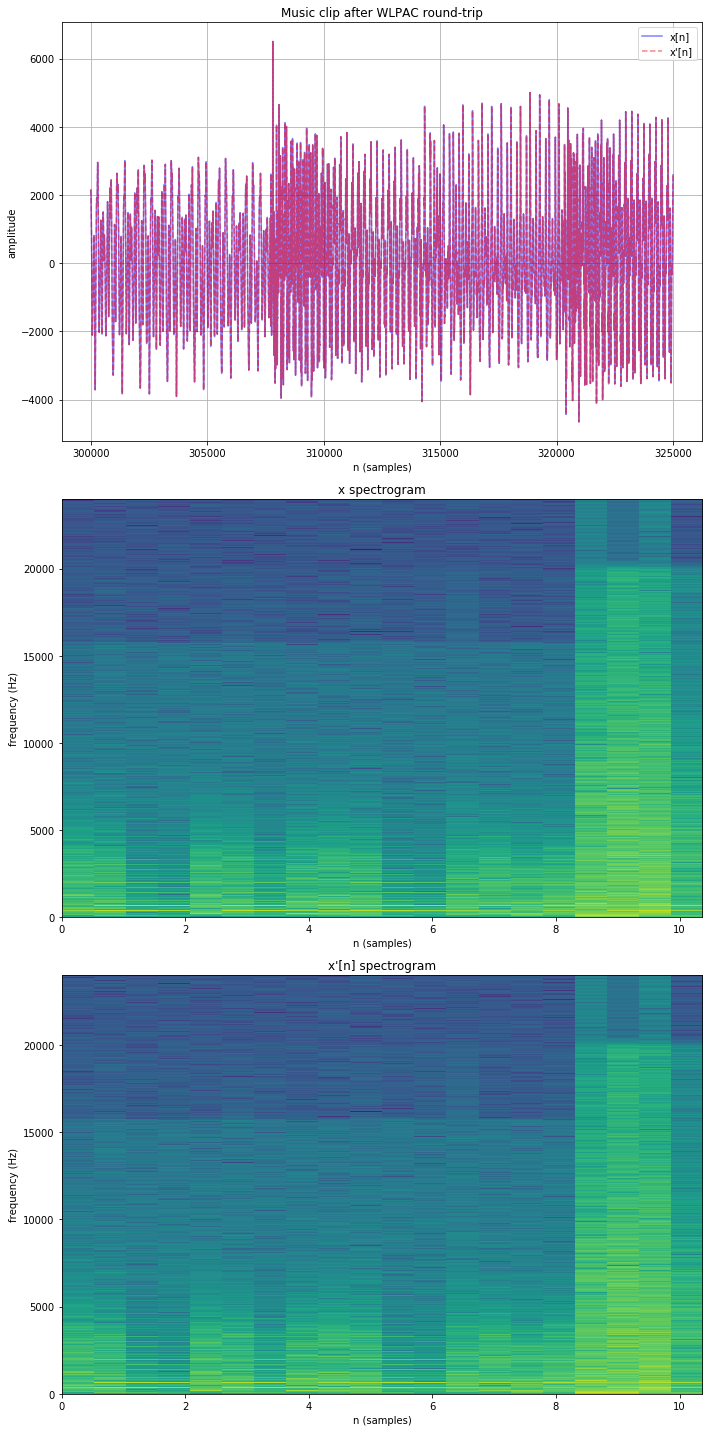

In [11]:
l = 300000
r = 325000
samples = numpy.arange(r)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 20))

ax1.plot(samples[l:r], x[l:r], 'b', alpha=0.5, label='x[n]')
ax1.set_title(r'Music clip after WLPAC round-trip')
ax1.set_xlabel('n (samples)')
ax1.set_ylabel('amplitude')
ax1.plot(samples[l:r], x_wlpac[l:r], 'r', linestyle='--', alpha=0.5, label='x\'[n]')
ax1.grid()
ax1.legend(loc='upper right')

Pxx1, freqs1, bins1, im1 = ax2.specgram(x, NFFT=r-l, Fs=fs)
ax2.set_title('x spectrogram')
ax2.set_xlabel('n (samples)')
ax2.set_ylabel('frequency (Hz)')

Pxx2, freqs2, bins2, im2 = ax3.specgram(x_wlpac, NFFT=r-l, Fs=fs)
ax3.set_title('x\'[n] spectrogram')
ax3.set_xlabel('n (samples)')
ax3.set_ylabel('frequency (Hz)')

plt.axis('tight')
fig.tight_layout()
plt.show()

## Conclusion

We built a lossy perceptual audio codec, saved to disk with Pickle + LZMA. The reconstruction sounds good (subjectively), and the waveform looks similar to the original signal.

## References

1. Härmä, Aki & Laine, Unto & M, Karjalainen. (1997). WLPAC—a perceptual audio codec in a nutshell.

2. Härmä, Aki & Laine, Unto & Karjalainen, M. (1997). An experimental audio codec based on warped linear prediction of complex valued signals. 1. 323 - 326 vol.1. 10.1109/ICASSP.1997.599638.